# Waterhackweek 2020 Project - SnowGW: basin water budget components

Based off of original code by [Emilio Mayorga](https://github.com/emiliom), University of Washington &mdash; [WaterHackWeek 2020](https://waterhackweek.github.io/). See Emilio's original script [mashup_waterbudget.ipynb](https://github.com/waterhackweek/waterdata/blob/master/mashup_waterbudget.ipynb) for helpful information on data sources, packages, and functions.

## Goal

* Construct time series visualizations at daily and/or monthly timescales that show water budget components for basins with snow-groundwater dynamics of interest. (Interim)

## Objective

**Construct and analyze (sub)watershed-scale water budget components for the two example watersheds using geospatial watershed layers and a wide variety of water data, including:**

* HUC8 basin boundaries (and associated HUC10 and HUC12 sub-basins)
* Daymet precipitation and SWE (gridded, daily)
* MODIS SSEBop evapotranspiration (gridded, monthly)
* GRACE water storage anomalies (gridded, monthly)
* USGS NWIS discharge (point, daily)
* USGS groundwater level measurements (point, daily)
* SNOTEL SWE (point, daily)

## Cases

### ONLY works for OR case right now!
                                                  
**Clackamas, OR**
* HUC-8 Subbasin ID 17090011
* size 2442 km^2
* slope 24.2%
* Total stream length (km) 1810.4 km
* Land cover: evergreen forest (73%), shrub/scrub (10%)

**Upper South Platte, CO**
* HUC-8 Subbasin ID 10190002 
* size: 4,797 km²
* slope: 22.3%
* Total stream length (km) 2812.4 km
* Land cover: evergreen forest (50%), shrub/ scrub: 18%, grassland: 15%

----------------

<div class="alert alert-success" style="font-size:100%">
<b style="font-size:120%">Setup</b></br>
</div>

## Import packages

In [233]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import contextily as cx
import folium

import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import xarray as xr
import rioxarray
import regionmask as rm

from shapely.geometry import box
import pynhd as nhd
import pygeoogc as geoogc
import pygeoutils as geoutils
import hydrodata as hd

## Set the time period

To be reused with every dataset.

In [234]:
date_start = '2008-01-01'
date_end = '2018-12-31'

## Select basin

Select one of the case study basins' HUC8 codes (OR: `17090011`; CO: `10190002`)

We'll use the shorthand "sb" to refer to the "selected basin".

In [235]:
#sb_huc08code = '10190002'

sb_huc08code = '17090011'

----------------

<div class="alert alert-success" style="font-size:100%">
<b style="font-size:120%">Format basin</b></br>
</div>

### Create HUC10 subwatersheds by first reading HUC12 subwatersheds

Request all HUC12 watersheds whose HUC12 code includes the sb code.

In [236]:
def wfs_getfeatures_cqlfilter(wd, cql_filter=None):
    """
    Use hydrodata packages to issue and process a OpenGeospatial Consortium (OGC) Web Feature Service (WFS) 
    request for WBD watersheds, with an optional filter to obtain only the watersheds we want.
    Returns a nice and clean GeoPandas GeoDataframe in "lat-lon" projection (epsg:4326)
    """
    payload = {
        "service": "wfs",
        "request": "GetFeature",
        "version": wd.version,
        "outputFormat": wd.outformat,
        "typeName": wd.layer,
    }
    if type(cql_filter) is str:
        payload["cql_filter"] = cql_filter

    r = geoogc.RetrySession().get(wd.url, payload)
    
    return geoutils.json2geodf(r.json(), "epsg:4326", crs="epsg:4326")

In [237]:
sb_wdhuc12 = nhd.WaterData('huc12', crs='epsg:4269')

In [238]:
print(sb_wdhuc12.get_validnames())

['huc12', 'tohuc', 'areaacres', 'areasqkm', 'name', 'hutype', 'humod', 'states', 'noncontrib', 'bbox']


In [239]:
# HUC filter (cql_filter) will be the string "huc12 LIKE '17030001%'"
sb_huc12_gdf = wfs_getfeatures_cqlfilter(
    sb_wdhuc12, 
    cql_filter=f"huc12 LIKE '{sb_huc08code}%'"
)

sb_huc12_gdf.head(2)

,geometry,huc12,tohuc,areaacres,areasqkm,name,hutype,humod,states,noncontrib,bbox
0,"MULTIPOLYGON (((-122.11810 44.87790, -122.1171...",170900110101,170900110103,10218.364276,41.352253,Upper Hot Springs Fork Collawash River,S,NM,OR,0,"[-122.2082, 44.8645, -122.1162, 44.9536]"
1,"MULTIPOLYGON (((-121.81240 44.81170, -121.8163...",170900110201,170900110203,14882.940694,60.229124,Cub Creek,S,NM,OR,0,"[-121.956, 44.8004, -121.8123, 44.9064]"


Create `huc10` column from `huc12` codes.

In [240]:
sb_huc12_gdf['huc10'] = sb_huc12_gdf.huc12.str[:-2]
cols = ['huc10', 'areasqkm', 'geometry']
sb_huc10_gdf = sb_huc12_gdf[cols].dissolve(by='huc10', aggfunc='sum', as_index=False)

len(sb_huc10_gdf)

6

In [241]:
sb_huc10_gdf.head(2)

,huc10,geometry,areasqkm
0,1709001101,"POLYGON ((-122.01470 44.84950, -122.01990 44.8...",394.544996
1,1709001102,"POLYGON ((-121.81240 44.81170, -121.81630 44.8...",408.515994


Use the `total_bounds` GeoDataFrame function to extract the outer bounding box coordinates, then create a simple GeoSeries out of that rectangle for reuse later on.

In [242]:
sb_huc10_gdf.total_bounds

array([-122.6089,   44.8004, -121.6515,   45.4562])

In [243]:
sb_bbox = gpd.GeoSeries(box(*sb_huc10_gdf.total_bounds), crs=sb_huc10_gdf.crs)

Set `xarray` spatial (lat & lon) "slices" here, for reuse below when doing lat-lon region clipping (via the `.sel` method) of `xarray` datasets.

In [244]:
sb_lon_slice = slice(sb_bbox.bounds.minx[0], sb_bbox.bounds.maxx[0])
sb_lat_slice = slice(sb_bbox.bounds.miny[0], sb_bbox.bounds.maxy[0])

Plot HUC8 basin + HUC10 sub-basins

In [245]:
# Note: There are other basemap tiles besides StamenTerrain
m = folium.Map(tiles='StamenTerrain', attr='ESRI')

In [246]:
# Bounding box
folium.GeoJson(
    sb_bbox.geometry,
    style_function=lambda feature: {'color': 'red', 'fillOpacity': 0.0}
).add_to(m)

# Set the map extent (bounds) to the extent of the bounding box
m.fit_bounds(m.get_bounds())

# HUC10 sub-watershed polygons
for i, i_gdf in sb_huc10_gdf.iterrows():
    folium.GeoJson(
        i_gdf.geometry,
        style_function=lambda feature: {'color': 'black', 'fillOpacity': 0.0},
        tooltip=i_gdf['huc10']
    ).add_child(
        folium.Popup(f"<b>HUC10:</b><br> {i_gdf['huc10']}<br><b>watershed area:</b><br> {i_gdf['areasqkm']:.0f} km^2")
    ).add_to(m)

In [247]:
m

----------------

<div class="alert alert-success" style="font-size:100%">
<b style="font-size:120%">Read data, and extract over selection (time and basin) </b></br>
</div>

## Precipitation and SWE from DayMet

### Get metadata ("lazy loading")

In [248]:
daymet_opendap_url = "https://thredds.daac.ornl.gov/thredds-daymet/dodsC/daymet-v3-agg/na.ncml"
    
daymet_ds = xr.open_dataset(daymet_opendap_url)

### Get the selected basin bounding box in the DayMet projection coordinates

In [249]:
daymet_ds_grid_mapping_name = 'lambert_conformal_conic'

In [250]:
# DayMet crs information is in: ds.lambert_conformal_conic ('lcc')
lcc_crs = CRS.from_cf(daymet_ds[daymet_ds_grid_mapping_name].attrs)

In [251]:
# Reproject our bounding box polygon into this new coordinate system, to use in our request
sb_bbox_lcc = sb_bbox.to_crs(lcc_crs)

In [252]:
sb_lcc_bnd = sb_bbox_lcc.bounds

### Get the DayMet data for the selected XYT "cube"

In [253]:
sb_daymet_da = daymet_ds.sel(
    time=slice(date_start, date_end),
    x=slice(sb_lcc_bnd.minx[0], sb_lcc_bnd.maxx[0]),
    y=slice(sb_lcc_bnd.maxy[0], sb_lcc_bnd.miny[0]) # note the reversed y values!
)

Select precipitation and SWE

In [254]:
sb_daymet_da_prcp = sb_daymet_da.prcp
sb_daymet_da_swe = sb_daymet_da.swe

### Reproject to lat-lon (to use with other data)

In [255]:
def reproject_da_as_ds(da, from_grid_mapping_name, from_crs, to_crs):
    """
    Reproject an xarray DataArray using rioxarray and the expectation of CF convention 
    for projection information.
    This function is fairly generic and can be reused with other datasets with only small changes.
    Returns an xarray DataSet with the expected, CF-convention projection information.
    """
    ds = da.to_dataset()
    # Use rioxarray to improve (clean up) the CRS metadata, 
    # so it can be used in the reprojection step
    ds.rio.write_crs(from_crs.to_string(), inplace=True)
    
    # Reproject the xarray dataset
    # Note: the drop_vars step could be done outside this function, since it's source-data cleanup
    reproj_ds = (
        ds
        .drop_vars(['lon', 'lat'])
        .rio.reproject(to_crs)
    )
    
    # Clean up the projection information and coordinates of the reprojected dataset
    to_grid_mapping_name = reproj_ds[from_grid_mapping_name].attrs['grid_mapping_name']
    reproj_ds = (
        reproj_ds
        .rio.set_spatial_dims('x', 'y')
        .rio.write_crs(to_crs)
        .rename({"x": "lon", "y": "lat", from_grid_mapping_name: to_grid_mapping_name}) 
        # this last step applies only when reprojecting to lat-lon
    )
    reproj_ds.attrs['grid_mapping'] = to_grid_mapping_name
    reproj_ds[da.name].attrs['grid_mapping'] = to_grid_mapping_name
    
    return reproj_ds

In [256]:
sb_daymet_ds_prcp = reproject_da_as_ds(sb_daymet_da_prcp, daymet_ds_grid_mapping_name, lcc_crs, "epsg:4326")
sb_daymet_ds_swe = reproject_da_as_ds(sb_daymet_da_swe, daymet_ds_grid_mapping_name, lcc_crs, "epsg:4326")

Quick check on the resulting cell sizes, in degrees

In [257]:
def print_cellsizes(dimcoord):
    print(dimcoord.values[1] - dimcoord.values[0], dimcoord.values[-1] - dimcoord.values[-2])

In [258]:
print_cellsizes(sb_daymet_ds_prcp.lon)
print_cellsizes(sb_daymet_ds_swe.lon)

0.012512596453134961 0.012512596453134961
0.012512596453134961 0.012512596453134961


In [259]:
print_cellsizes(sb_daymet_ds_prcp.lat)
print_cellsizes(sb_daymet_ds_swe.lat)

-0.012512596453142066 -0.012512596453142066
-0.012512596453142066 -0.012512596453142066


Clip to basin polygon boundary

In [260]:
sb_daymet_ds_prcp = sb_daymet_ds_prcp.rio.clip(sb_huc10_gdf.geometry, all_touched=True)
sb_daymet_ds_swe = sb_daymet_ds_swe.rio.clip(sb_huc10_gdf.geometry, all_touched=True)

Look ("5th time step from the end")

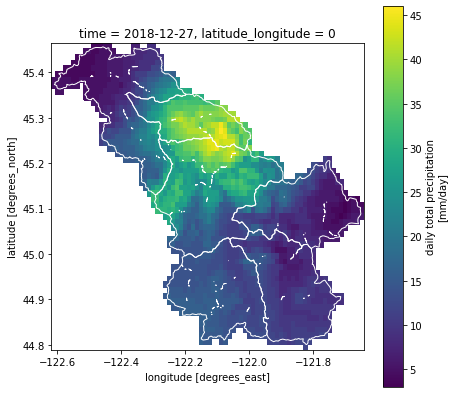

In [261]:
f, ax = plt.subplots(1, figsize=(7, 7))
sb_daymet_ds_prcp.prcp.isel(time=-5).plot(ax=ax)
sb_huc10_gdf.plot(ax=ax, edgecolor='white', facecolor='none');

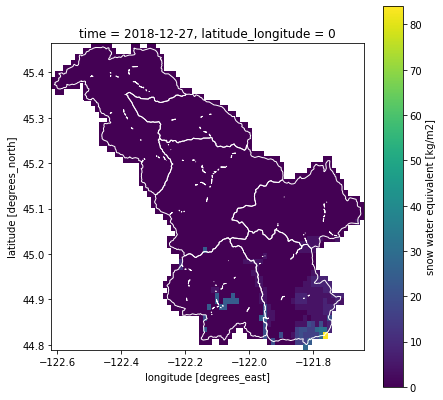

In [262]:
f, ax = plt.subplots(1, figsize=(7, 7))
sb_daymet_ds_swe.swe.isel(time=-5).plot(ax=ax)
sb_huc10_gdf.plot(ax=ax, edgecolor='white', facecolor='none');

## ETa from MODIS SSEBop

In [263]:
ssebop_opendap_url = "https://cida.usgs.gov/thredds/dodsC/ssebopeta/monthly"

ssebop_ds = xr.open_dataset(ssebop_opendap_url)

In [264]:
ssebop_ds

<xarray.Dataset>
Dimensions:  (lat: 2834, lon: 6612, time: 238)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2019-10-01
  * lon      (lon) float64 -126.0 -126.0 -126.0 -126.0 ... -66.51 -66.51 -66.5
  * lat      (lat) float64 24.0 24.01 24.02 24.03 ... 49.47 49.48 49.49 49.5
Data variables:
    crs      |S64 ...
    et       (time, lat, lon) float32 ...
Attributes:
    Conventions:                     CF-1.5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    title:                           Conterminous U.S. actual evapotranspirat...
    creator_name:                    Stefanie Kagone
    creator_email:                   skagone@contractor.usgs.gov
    summary:                         Actual ET (ETa) is produced using the op...
    cdm_data_type:                   Grid
    date_created:                    February, 2013
    date_modified:                   December, 2019
    creator_url:                     https://earlywarning.usgs.gov/ssebop/modis
    publisher_name:                  David Blodgett
    publisher_url:                   https://cida.usgs.gov/
    publisher_email:                 dblodgett@usgs.gov
    institution:                     U.S. Geological Survey
    date_issued:                     February, 2013
    project:                         WaterSMART National Water Census
    processing_level:                Refer to documentation.
    acknowledgement:                 Senay, G.B., M. Budde, J.P. Verdin, and ...
    contributors:                    Senay, G.B., S. Bohms, R. Singh, P.A. Go...
    geospatial_lat_min:              24
    geospatial_lat_max:              49.5
    geospatial_lon_min:              -126
    geospatial_lon_max:              -66.5
    time_coverage_resolution:        P1Y
    license:                         Freely available
    DODS.strlen:                     238
    DODS.dimName:                    time
    DODS_EXTRA.Unlimited_Dimension:  time

In [265]:
ssebop_ds.rio.write_crs(CRS.from_cf(ssebop_ds['crs'].attrs), inplace=True);

In [266]:
ssebop_ds.time.values[0:3]

array(['2000-01-01T00:00:00.000000000', '2000-02-01T00:00:00.000000000',
       '2000-03-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [267]:
sb_ssebop_et_ds = ssebop_ds.sel(time=slice(date_start, date_end), lon=sb_lon_slice, lat=sb_lat_slice)

sb_ssebop_et_ds

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 106, time: 132)
Coordinates:
  * time     (time) datetime64[ns] 2008-01-01 2008-02-01 ... 2018-12-01
    crs      int64 0
  * lon      (lon) float64 -122.6 -122.6 -122.6 -122.6 ... -121.7 -121.7 -121.7
  * lat      (lat) float64 44.81 44.82 44.82 44.83 ... 45.43 45.44 45.45 45.45
Data variables:
    et       (time, lat, lon) float32 ...
Attributes:
    Conventions:                     CF-1.5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    title:                           Conterminous U.S. actual evapotranspirat...
    creator_name:                    Stefanie Kagone
    creator_email:                   skagone@contractor.usgs.gov
    summary:                         Actual ET (ETa) is produced using the op...
    cdm_data_type:                   Grid
    date_created:                    February, 2013
    date_modified:                   December, 2019
    creator_url:                     https://earlywarning.usgs.gov/ssebop/modis
    publisher_name:                  David Blodgett
    publisher_url:                   https://cida.usgs.gov/
    publisher_email:                 dblodgett@usgs.gov
    institution:                     U.S. Geological Survey
    date_issued:                     February, 2013
    project:                         WaterSMART National Water Census
    processing_level:                Refer to documentation.
    acknowledgement:                 Senay, G.B., M. Budde, J.P. Verdin, and ...
    contributors:                    Senay, G.B., S. Bohms, R. Singh, P.A. Go...
    geospatial_lat_min:              24
    geospatial_lat_max:              49.5
    geospatial_lon_min:              -126
    geospatial_lon_max:              -66.5
    time_coverage_resolution:        P1Y
    license:                         Freely available
    DODS.strlen:                     238
    DODS.dimName:                    time
    DODS_EXTRA.Unlimited_Dimension:  time
    grid_mapping:                    crs

In [268]:
sb_ssebop_et_ds = sb_ssebop_et_ds.rio.clip(sb_huc10_gdf.geometry, all_touched=True)

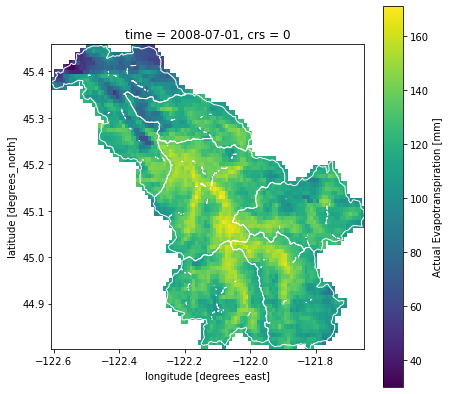

In [269]:
f, ax = plt.subplots(1, figsize=(7, 7))
sb_ssebop_et_ds.et.isel(time=6).plot(ax=ax)
sb_huc10_gdf.plot(ax=ax, edgecolor='white', facecolor='none');

## TWS anomalies from GRACE

In [270]:
grace_opendap_url = "https://podaac-opendap.jpl.nasa.gov/opendap/allData/tellus/L3/mascon/RL06/JPL/v02/CRI/netcdf/GRCTellus.JPL.200204_202007.GLO.RL06M.MSCNv02CRI.nc"

grace_ds = xr.open_dataset(grace_opendap_url)

In [271]:
grace_ds

<xarray.Dataset>
Dimensions:        (bounds: 2, lat: 360, lon: 720, time: 187)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2020-07-16T1...
Dimensions without coordinates: bounds
Data variables:
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (time, bounds) datetime64[ns] ...
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
Attributes:
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    platform:                      GRACE and GRACE-FO
    institution:                   NASA/JPL
    creator_name:                  David Wiese
    creator_email:                 grace@podaac.jpl.nasa.gov
    creator_url:                   https://grace.jpl.nasa.gov
    creator_type:                  group
    creator_institution:           NASA/JPL
    publisher_name:                Physical Oceanography Distributed Active A...
    publisher_email:               podaac@jpl.nasa.gov
    publisher_url:                 https://podaac.jpl.nasa.gov
    publisher_type:                group
    publisher_institution:         NASA/JPL
    project:                       NASA Gravity Recovery and Climate Experime...
    program:                       NASA Earth Science System Pathfinder and N...
    id:                            10.5067/TEMSC-3JC62
    naming_authority:              org.doi.dx
    source:                        GRACE and GRACE-FO JPL RL06Mv2-CRI
    processing_level:              2 and 3
    acknowledgement:               GRACE is a joint mission of NASA (USA) and...
    license:                       https://science.nasa.gov/earth-science/ear...
    product_version:               v2.0
    time_epoch:                    2002-01-01T00:00:00Z
    time_coverage_start:           2002-04-16T00:00:00Z
    time_coverage_end:             2020-07-16T23:59:59Z
    geospatial_lat_min:            -89.75
    geospatial_lat_max:            89.75
    geospatial_lat_units:          degrees_north
    geospatial_lat_resolution:     0.5 degree grid; however the native resolu...
    geospatial_lon_min:            0.25
    geospatial_lon_max:            359.75
    geospatial_lon_units:          degrees_east
    geospatial_lon_resolution:     0.5 degree grid; however the native resolu...
    time_mean_removed:             2004.000 to 2009.999
    months_missing:                2002-06;2002-07;2003-06;2011-01;2011-06;20...
    postprocess_1:                  OCEAN_ATMOSPHERE_DEALIAS_MODEL (GAD), MON...
    postprocess_2:                 Water density used to convert to equivalen...
    postprocess_3:                 Coastline Resolution Improvement (CRI) fil...
    GIA_removed:                   ICE6G-D; Peltier, W. R., D. F. Argus, and ...
    geocenter_correction:          We use a version of TN-13 based on the JPL...
    C_20_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...


In [272]:
grace_ds.lon.values.min(), grace_ds.lon.values.max()

(0.25, 359.75)

**NOTE:** `lon` values are 0 - 360 (starting from the anti-meridian, "-180") rather than -180 to 180 as the previous datasets; add an offset in the lon slice specification, and shift the xarray dataset to make it work with the region mask and GeoDataFrame overlays.

In [273]:
sb_grace_lwe_thickness_ds = grace_ds.sel(
    time=slice(date_start, date_end), 
    lon=slice(360 + sb_bbox.bounds.minx[0] - 0.5, 360 + sb_bbox.bounds.maxx[0] + 0.5), 
    lat=slice(sb_bbox.bounds.miny[0] - 0.5, sb_bbox.bounds.maxy[0] + 0.5), 
)

sb_grace_lwe_thickness_ds

<xarray.Dataset>
Dimensions:        (bounds: 2, lat: 3, lon: 4, time: 102)
Coordinates:
  * lon            (lon) float64 237.2 237.8 238.2 238.8
  * lat            (lat) float64 44.75 45.25 45.75
  * time           (time) datetime64[ns] 2008-01-16T12:00:00 ... 2018-12-16T1...
Dimensions without coordinates: bounds
Data variables:
    lat_bounds     (lat, bounds) float64 44.5 45.0 45.0 45.5 45.5 46.0
    lon_bounds     (lon, bounds) float64 237.0 237.5 237.5 ... 238.5 238.5 239.0
    time_bounds    (time, bounds) datetime64[ns] 2008-01-01 ... 2018-12-31T23...
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
Attributes:
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    platform:                      GRACE and GRACE-FO
    institution:                   NASA/JPL
    creator_name:                  David Wiese
    creator_email:                 grace@podaac.jpl.nasa.gov
    creator_url:                   https://grace.jpl.nasa.gov
    creator_type:                  group
    creator_institution:           NASA/JPL
    publisher_name:                Physical Oceanography Distributed Active A...
    publisher_email:               podaac@jpl.nasa.gov
    publisher_url:                 https://podaac.jpl.nasa.gov
    publisher_type:                group
    publisher_institution:         NASA/JPL
    project:                       NASA Gravity Recovery and Climate Experime...
    program:                       NASA Earth Science System Pathfinder and N...
    id:                            10.5067/TEMSC-3JC62
    naming_authority:              org.doi.dx
    source:                        GRACE and GRACE-FO JPL RL06Mv2-CRI
    processing_level:              2 and 3
    acknowledgement:               GRACE is a joint mission of NASA (USA) and...
    license:                       https://science.nasa.gov/earth-science/ear...
    product_version:               v2.0
    time_epoch:                    2002-01-01T00:00:00Z
    time_coverage_start:           2002-04-16T00:00:00Z
    time_coverage_end:             2020-07-16T23:59:59Z
    geospatial_lat_min:            -89.75
    geospatial_lat_max:            89.75
    geospatial_lat_units:          degrees_north
    geospatial_lat_resolution:     0.5 degree grid; however the native resolu...
    geospatial_lon_min:            0.25
    geospatial_lon_max:            359.75
    geospatial_lon_units:          degrees_east
    geospatial_lon_resolution:     0.5 degree grid; however the native resolu...
    time_mean_removed:             2004.000 to 2009.999
    months_missing:                2002-06;2002-07;2003-06;2011-01;2011-06;20...
    postprocess_1:                  OCEAN_ATMOSPHERE_DEALIAS_MODEL (GAD), MON...
    postprocess_2:                 Water density used to convert to equivalen...
    postprocess_3:                 Coastline Resolution Improvement (CRI) fil...
    GIA_removed:                   ICE6G-D; Peltier, W. R., D. F. Argus, and ...
    geocenter_correction:          We use a version of TN-13 based on the JPL...
    C_20_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D.

In [274]:
sb_grace_lwe_thickness_ds.coords['lon'] = (sb_grace_lwe_thickness_ds.coords['lon'] + 180) % 360 - 180
sb_grace_lwe_thickness_ds = sb_grace_lwe_thickness_ds.sortby(sb_grace_lwe_thickness_ds.lon)

In [275]:
sb_grace_lwe_thickness_ds

<xarray.Dataset>
Dimensions:        (bounds: 2, lat: 3, lon: 4, time: 102)
Coordinates:
  * lon            (lon) float64 -122.8 -122.2 -121.8 -121.2
  * lat            (lat) float64 44.75 45.25 45.75
  * time           (time) datetime64[ns] 2008-01-16T12:00:00 ... 2018-12-16T1...
Dimensions without coordinates: bounds
Data variables:
    lat_bounds     (lat, bounds) float64 44.5 45.0 45.0 45.5 45.5 46.0
    lon_bounds     (lon, bounds) float64 237.0 237.5 237.5 ... 238.5 238.5 239.0
    time_bounds    (time, bounds) datetime64[ns] 2008-01-01 ... 2018-12-31T23...
    lwe_thickness  (time, lat, lon) float64 9.411 9.411 9.411 ... -11.61 -11.61
    uncertainty    (time, lat, lon) float64 3.175 3.175 3.175 ... 2.7 2.7 2.7
Attributes:
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    platform:                      GRACE and GRACE-FO
    institution:                   NASA/JPL
    creator_name:                  David Wiese
    creator_email:                 grace@podaac.jpl.nasa.gov
    creator_url:                   https://grace.jpl.nasa.gov
    creator_type:                  group
    creator_institution:           NASA/JPL
    publisher_name:                Physical Oceanography Distributed Active A...
    publisher_email:               podaac@jpl.nasa.gov
    publisher_url:                 https://podaac.jpl.nasa.gov
    publisher_type:                group
    publisher_institution:         NASA/JPL
    project:                       NASA Gravity Recovery and Climate Experime...
    program:                       NASA Earth Science System Pathfinder and N...
    id:                            10.5067/TEMSC-3JC62
    naming_authority:              org.doi.dx
    source:                        GRACE and GRACE-FO JPL RL06Mv2-CRI
    processing_level:              2 and 3
    acknowledgement:               GRACE is a joint mission of NASA (USA) and...
    license:                       https://science.nasa.gov/earth-science/ear...
    product_version:               v2.0
    time_epoch:                    2002-01-01T00:00:00Z
    time_coverage_start:           2002-04-16T00:00:00Z
    time_coverage_end:             2020-07-16T23:59:59Z
    geospatial_lat_min:            -89.75
    geospatial_lat_max:            89.75
    geospatial_lat_units:          degrees_north
    geospatial_lat_resolution:     0.5 degree grid; however the native resolu...
    geospatial_lon_min:            0.25
    geospatial_lon_max:            359.75
    geospatial_lon_units:          degrees_east
    geospatial_lon_resolution:     0.5 degree grid; however the native resolu...
    time_mean_removed:             2004.000 to 2009.999
    months_missing:                2002-06;2002-07;2003-06;2011-01;2011-06;20...
    postprocess_1:                  OCEAN_ATMOSPHERE_DEALIAS_MODEL (GAD), MON...
    postprocess_2:                 Water density used to convert to equivalen...
    postprocess_3:                 Coastline Resolution Improvement (CRI) fil...
    GIA_removed:                   ICE6G-D; Peltier, W. R., D. F. Argus, and ...
    geocenter_correction:          We use a version of TN-13 based on the JPL...
    C_20_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wi

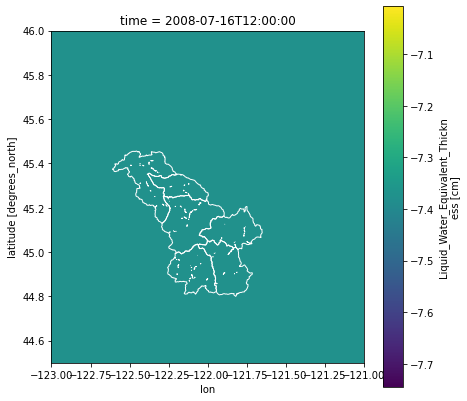

In [276]:
f, ax = plt.subplots(1, figsize=(7, 7))
sb_grace_lwe_thickness_ds.lwe_thickness.isel(time=6).plot(ax=ax)
sb_huc10_gdf.plot(ax=ax, edgecolor='white', facecolor='none');

## Discharge from USGS NWIS

Use `hydrodata.interactive_map`: for HUC10 subbasin boundaries, produce clickable site markers.

In [277]:
m2 = hd.interactive_map(tuple(sb_bbox.total_bounds))

In [278]:
for i, i_gdf in sb_huc10_gdf.iterrows():
    folium.GeoJson(
        i_gdf.geometry,
        style_function=lambda feature: {'color': 'black', 'fillOpacity': 0.0},
        tooltip=i_gdf['huc10']
    ).add_child(
        folium.Popup(f"<b>HUC10:</b><br> {i_gdf['huc10']}<br><b>watershed area:</b><br> {i_gdf['areasqkm']:.0f} km^2")
    ).add_to(m2)


m2.fit_bounds(m2.get_bounds())

In [279]:
m2

Lookup site metadata (including dates) for selection...

In [280]:
nwis = hd.NWIS()

In [282]:
sb_stations_info_df = nwis.get_info(nwis.query_bybox(tuple(sb_bbox.total_bounds)))
sb_stations_info_df.head()

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,...,ts_id,loc_web_ds,medium_grp_cd,parm_grp_cd,srs_id,access_cd,begin_date,end_date,count_nu,hcdn_2009
0,USGS,14097400,"CLEAR CREEK BL CLEAR LAKE, NR GOVT CAMP,OREG.",ST,45.176229,-121.694242,U,NAD83,3477.64,0.1,...,113446,,wat,,1645423,0,1968-06-01,1973-08-31,1918,False
1,USGS,14097500,"CLEAR CREEK NEAR GOVERNMENT CAMP,OREG.",ST,45.172062,-121.684520,U,NAD83,3450.94,0.1,...,113447,,wat,,1645423,0,1946-10-01,1953-09-29,2556,False
2,USGS,14130000,"LOST CREEK NR BRIGHTWOOD, OREG.",ST,45.374841,-121.884524,U,NAD83,1800.00,20,...,113493,,wat,,1645423,0,1913-10-01,1918-09-29,1825,False
3,USGS,14131000,LITLE ZIGZAG R TWIN BRDGS RHODODENDRON OREG.,ST,45.313730,-121.809523,U,NAD83,2905.16,0.1,...,113494,,wat,,1645423,0,1926-04-01,1936-09-29,3835,False
5,USGS,14131500,"ZIGZAG RIVER AT RHODODENDRON, OREG.",ST,45.327619,-121.909524,U,NAD83,1640.00,20,...,113496,,wat,,1645423,0,1920-01-01,1930-09-29,2053,False


Get station data

In [283]:
nearestoutlet_sitecode = '14211010'

With `mmd=True`, `nwis.get_streamflow` converts cms (cubic meters / second) to mmd (mm/day) based on the contributing drainage area of the station.

In [284]:
nwis_q_daily_ts = nwis.get_streamflow([nearestoutlet_sitecode], dates=(date_start, date_end), mmd=True)

In [285]:
nwis_q_daily_ts.head()

,USGS-14211010
dateTime,
2008-01-01,3.978013
2008-01-02,3.747549
2008-01-03,4.008074
2008-01-04,4.679426
2008-01-05,5.310698


Resample to daily and tweak it so it's consistent with the other watershed-scale time series. 

NOTE: how to input nearestoutlet_sitecode as a variable below (instead of column site name directly)??

In [286]:
nwis_q_ts_df = nwis_q_daily_ts.resample('1M').sum()
# nwis_q_ts_df.index = nwis_q_ts_df.index.month
# nwis_q_ts_df.index.name = 'month'
nwis_q_ts_df.rename(columns={'USGS-14211010': 'disch'}, inplace=True)

nwis_q_ts_df

,disch
dateTime,
2008-01-31,153.008225
2008-02-29,110.803206
2008-03-31,139.330672
2008-04-30,108.979532
2008-05-31,238.139717
...,...
2018-08-31,24.761881
2018-09-30,24.334019
2018-10-31,28.566545


## Groundwater level from USGS

Import GW data generated by [GWdata.ipynb](https://github.com/waterhackweek/whw2020_snowgw/blob/master/GWdata.ipynb)

In [287]:
sb_gw = pd.read_csv("data/ORgw.csv")

In [288]:
sb_gw.rename(columns={'116034_72019_00003': 'gw'}, inplace=True)

In [289]:
sb_gw.dtypes

agency_cd                 object
site_no                    int64
datetime                  object
gw                       float64
116034_72019_00003_cd     object
dtype: object

In [290]:
sb_gw.head()

,agency_cd,site_no,datetime,gw,116034_72019_00003_cd
0,USGS,452033122195901,2001-09-07,63.97,A
1,USGS,452033122195901,2001-09-08,63.84,A
2,USGS,452033122195901,2001-09-09,63.70,A
3,USGS,452033122195901,2001-09-10,63.85,A
4,USGS,452033122195901,2001-09-11,63.95,A


In [291]:
sb_gw['datetime'] =  pd.to_datetime(sb_gw['datetime'], format='%Y-%m-%d')
sb_gw.head()

,agency_cd,site_no,datetime,gw,116034_72019_00003_cd
0,USGS,452033122195901,2001-09-07,63.97,A
1,USGS,452033122195901,2001-09-08,63.84,A
2,USGS,452033122195901,2001-09-09,63.70,A
3,USGS,452033122195901,2001-09-10,63.85,A
4,USGS,452033122195901,2001-09-11,63.95,A


In [292]:
sb_gw=sb_gw.set_index(sb_gw.datetime)

In [293]:
sb_gw=sb_gw.loc[slice(date_start,date_end)]
sb_gw

,agency_cd,site_no,datetime,gw,116034_72019_00003_cd
datetime,,,,,
2008-01-01,USGS,452033122195901,2008-01-01,63.65,A
2008-01-02,USGS,452033122195901,2008-01-02,63.38,A
2008-01-03,USGS,452033122195901,2008-01-03,63.01,A
2008-01-04,USGS,452033122195901,2008-01-04,62.52,A
2008-01-05,USGS,452033122195901,2008-01-05,63.02,A
...,...,...,...,...,...
2018-12-27,USGS,452033122195901,2018-12-27,63.92,A
2018-12-28,USGS,452033122195901,2018-12-28,63.95,A
2018-12-29,USGS,452033122195901,2018-12-29,63.78,A


Aggregate to monthly (mean) and label units

In [294]:
sb_gw_ts_df = sb_gw.resample('1M').mean()
#sb_gw_ts_df.index = sb_gw_ts_df.index.month
#sb_gw_ts_df.index.name = 'month'
sb_gw_ts_df = sb_gw_ts_df[['gw']]

sb_gw_ts_df.attrs['long_name'] = 'monthly mean water level - depth below surface'
sb_gw_ts_df.attrs['units'] = 'feet'

sb_gw_ts_df

,gw
datetime,
2008-01-31,63.449355
2008-02-29,63.017931
2008-03-31,62.409355
2008-04-30,61.869000
2008-05-31,61.614194
...,...
2018-08-31,62.231290
2018-09-30,62.951333
2018-10-31,62.861290


## SWE from SNOTEL

Import SWE from csv generated by [BuildBD.ipynb](https://github.com/waterhackweek/whw2020_snowgw/blob/master/BuildDB.ipynb)

In [295]:
snow_stn = pd.read_csv("data/OR_DB.csv",dtype={'huc2':object,'huc4':object,'huc6':object,
                                               'huc8':object,'huc10':object,'huc12':object})
snow_stn.head()

,Unnamed: 0,code,longitude,latitude,name,elevation_m,geometry,huc12,huc10,huc8,huc6,huc4,huc2,dem_elev,slope,aspect,pr
0,0,302_OR_SNTL,-117.192581,45.213280,Aneroid Lake #2,2255.520020,POINT (-117.1925811767578 45.21327972412109),170601050101,1706010501,17060105,170601,1706,17,2256,89.991560,263.659820,3.310440
1,1,1000_OR_SNTL,-122.165176,42.870071,Annie Springs,1831.848022,POINT (-122.1651763916016 42.87007141113281),180102030101,1801020301,18010203,180102,1801,18,1835,89.995480,186.788970,6.601648
2,2,304_OR_SNTL,-119.253922,45.190849,Arbuckle Mtn,1758.696045,POINT (-119.2539215087891 45.19084930419922),170702020604,1707020206,17070202,170702,1707,17,1770,89.975845,18.434948,1.412088
3,3,1166_OR_SNTL,-122.093803,44.325298,Bear Grass,1438.656006,POINT (-122.0938034057617 44.32529830932617),170900040203,1709000402,17090004,170900,1709,17,1444,89.996216,103.760790,6.565934
4,4,324_ID_SNTL,-116.980972,44.605331,Bear Saddle,1883.663940,POINT (-116.9809722900391 44.60533142089844),170501241001,1705012410,17050124,170501,1705,17,1882,89.995110,189.582950,3.395604


In [296]:
from shapely.geometry import Point
stn=snow_stn[snow_stn.huc8 == sb_huc08code]
stn=stn.reset_index(drop=True)
stn = gpd.GeoDataFrame(stn, crs="EPSG:4326", 
                       geometry=[Point(xy) for xy in zip(stn.longitude, stn.latitude)])
stn

,Unnamed: 0,code,longitude,latitude,name,elevation_m,geometry,huc12,huc10,huc8,huc6,huc4,huc2,dem_elev,slope,aspect,pr
0,16,398_OR_SNTL,-121.754433,45.096581,Clackamas Lake,1036.319946,POINT (-121.75443 45.09658),170900110301,1709001103,17090011,170900,1709,17,1056,89.99585,55.619656,2.489011
1,70,687_OR_SNTL,-121.932518,45.041481,Peavine Ridge,1042.416016,POINT (-121.93252 45.04148),170900110306,1709001103,17090011,170900,1709,17,1058,89.97413,298.300750,2.653846


In [297]:
import ulmo
wsdlurl = "http://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL"

def fetch(sitecode, variablecode, start_date, end_date):
    print(sitecode, variablecode, start_date, end_date)
    values_df = None
    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(
            wsdlurl, 'SNOTEL:'+sitecode, variablecode, start=start_date, end=end_date
        )
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'])
        #Set the DataFrame index to the Timestamps
        values_df.set_index('datetime', inplace=True)
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)
    
    return values_df


In [298]:
stn_swe = pd.DataFrame(index=pd.date_range(start=date_start, end=date_end))
for sitecode in stn.code:
    try:
        swe = fetch(sitecode, variablecode='SNOTEL:WTEQ_D', start_date=date_start, end_date=date_end)
        stn_swe[sitecode] = swe.value
    except:
        print(sitecode, 'has no data')
        stn_swe[sitecode] = np.nan

398_OR_SNTL SNOTEL:WTEQ_D 2008-01-01 2018-12-31
687_OR_SNTL SNOTEL:WTEQ_D 2008-01-01 2018-12-31


In [299]:
stn_swe.head()

,398_OR_SNTL,687_OR_SNTL
2008-01-01,8.2,12.8
2008-01-02,8.2,12.8
2008-01-03,8.2,12.9
2008-01-04,8.1,13.0
2008-01-05,8.3,13.3


Aggregate to monthly (mean)

In [300]:
stn_swe_ts_df = stn_swe.resample('1M').mean()
#stn_swe_ts_df.index = stn_swe_ts_df.index.month
#stn_swe_ts_df.index.name = 'month'

In [301]:
#sb_ts_df = sb_ts_df.groupby(pd.Grouper(freq='M')).first()
#sb_ts_df = sb_ts_df.interpolate(method='linear', axis=0).ffill().bfill()
    
stn_swe_ts_df

,398_OR_SNTL,687_OR_SNTL
2008-01-31,11.374194,17.538710
2008-02-29,20.479310,31.124138
2008-03-31,21.335484,33.719355
2008-04-30,21.016667,37.543333
2008-05-31,6.587097,22.903226
...,...,...
2018-08-31,0.000000,0.000000
2018-09-30,0.000000,0.000000
2018-10-31,0.000000,0.000000
2018-11-30,0.140000,0.066667


Subset to a single site (either one) and label units

In [302]:
stn_swe_ts_df.rename(columns={'398_OR_SNTL': 'stn_swe'}, inplace=True) # just renaming one
stn_swe_ts_df = stn_swe_ts_df[['stn_swe']]

stn_swe_ts_df.attrs['long_name'] = 'monthly mean SNOTEL SWE'
stn_swe_ts_df.attrs['units'] = 'mm/month'
stn_swe_ts_df

,stn_swe
2008-01-31,11.374194
2008-02-29,20.479310
2008-03-31,21.335484
2008-04-30,21.016667
2008-05-31,6.587097
...,...
2018-08-31,0.000000
2018-09-30,0.000000
2018-10-31,0.000000
2018-11-30,0.140000


----------------

<div class="alert alert-success" style="font-size:100%">
<b style="font-size:120%">Generate basin time series means using basin regions and mask (HUC10-level) </b></br>

### Create `regionmask` regions from a GeoDataFrame

<b>REGIONMASK LIMITATION:</b> <a href="https://github.com/mathause/regionmask/issues/151">regionmask is hard-wired to work only with data in lat-lon coordinates!</a>
</div>

In [303]:
sb_huc10_regions = rm.from_geopandas(
    sb_huc10_gdf, names="huc10", name="huc10"
)

sb_huc10_regions

<regionmask.Regions>
Name:     huc10

Regions:
 0  r0  1709001101
 1  r1  1709001102
 2  r2  1709001103
 3  r3  1709001104
 4  r4  1709001105
 5  r5  1709001106

[6 regions]

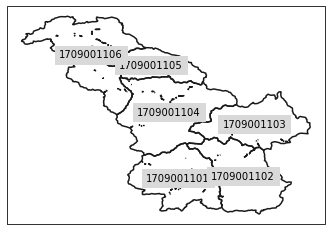

In [304]:
sb_huc10_regions.plot(label="name");

### HUC10 watershed time series means

In [305]:
def generate_huc10_ts(regions, ds, dsvarname, crsvar=None):
    """
    Use regionmask to create a gridded mask from the regions and the xarray dataset's
    grid resolution. Copy the variable attributes from the source DataSet to the 
    output DataArray.
    Returns a DataArray
    """
    mask3d = regions.mask_3D(ds, drop=False)

    # Latitude weighting for area-weighted averaging.
    # But it's probably unnecessary for this small geographical extent of the Upper Yakima
    weights = np.cos(np.deg2rad(ds.lat))
    regions_ts = ds[dsvarname].weighted(mask3d * weights).mean(dim=("lat", "lon"))
    # Assign dataarray name, and variable long name and units to region_ts, from ds[dsvarname]
    regions_ts.name = dsvarname
    regions_ts.attrs['long_name'] = ds[dsvarname].attrs['long_name']
    regions_ts.attrs['units'] = ds[dsvarname].attrs['units']
    
    # if present, drop crs variable b/c it's not needed anymore
    if crsvar in ds:
        regions_ts = regions_ts.drop_vars(crsvar)
    
    return regions_ts

#### Precipitation and SWE

In [306]:
daymet_prcp_regions_ts_daily = generate_huc10_ts(sb_huc10_regions, sb_daymet_ds_prcp, 'prcp', crsvar='latitude_longitude')
daymet_swe_regions_ts_daily = generate_huc10_ts(sb_huc10_regions, sb_daymet_ds_swe, 'swe', crsvar='latitude_longitude')

Aggregate (sum) to monthly resolution

In [307]:
daymet_prcp_regions_ts = daymet_prcp_regions_ts_daily.resample(time='1M').sum()
daymet_prcp_regions_ts.attrs['long_name'] = 'monthly total precipitation'
daymet_prcp_regions_ts.attrs['units'] = 'mm/month'

In [308]:
daymet_swe_regions_ts = daymet_swe_regions_ts_daily.resample(time='1M').mean()
daymet_swe_regions_ts.attrs['long_name'] = 'monthly mean SWE'
daymet_swe_regions_ts.attrs['units'] = 'mm/month' # km/m2 == mm

#### Evapotranspiration

In [309]:
ssebop_et_regions_ts = generate_huc10_ts(sb_huc10_regions, sb_ssebop_et_ds, 'et', crsvar='crs')

#### Water storage

In [310]:
grace_lwe_thickness_regions_ts = generate_huc10_ts(sb_huc10_regions, sb_grace_lwe_thickness_ds, 'lwe_thickness')

Convert units to mm, and update units attribute accordingly.

In [311]:
grace_lwe_thickness_regions_ts *= 10
grace_lwe_thickness_regions_ts.attrs['units'] = 'mm/month'

Plot spatial data summaries

In [312]:
yrange = 600 # in mm

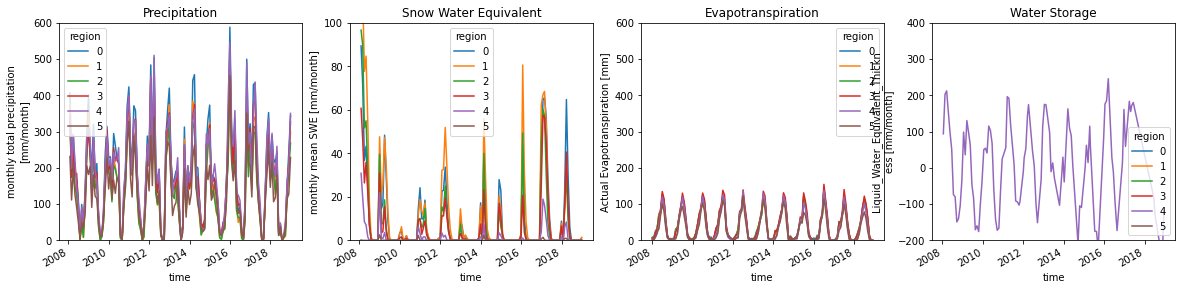

In [313]:
f, ax = plt.subplots(ncols=4,figsize=(20, 4))
daymet_prcp_regions_ts.plot(ax=ax[0], hue="region")
ax[0].set_title('Precipitation')
ax[0].set_ylim(0, yrange)
daymet_swe_regions_ts.plot(ax=ax[1], hue="region")
ax[1].set_title('Snow Water Equivalent')
ax[1].set_ylim(0, yrange-500)
ssebop_et_regions_ts.plot(ax=ax[2], hue="region")
ax[2].set_title('Evapotranspiration')
ax[2].set_ylim(0, yrange)
grace_lwe_thickness_regions_ts.plot(ax=ax[3], hue="region")
ax[3].set_title('Water Storage')
ax[3].set_ylim(-200, -200 + yrange);

### Whole-watershed DataFrames

Generate sb-wide PPT, SWE, ET and LWE_thickness time series from HUC10-level values.

In [314]:
sb_huc10_gdf['areaweight'] = sb_huc10_gdf.areasqkm.values / sb_huc10_gdf.areasqkm.sum()

In [315]:
def generate_sb_ts(da, davarname):
    """
    Calculate whole-watershed time series based on area-weighted averaging of
    HUC10-level time series, converting from DataArray to DataFrame.
    Returns a cleaned and consistent DataFrame
    """
    areawt = xr.DataArray(
        sb_huc10_gdf.areasqkm.values / sb_huc10_gdf.areasqkm.sum(), 
        dims=('region'), 
        coords={'region': sb_huc10_gdf.index}
    )
    sb_ts = da.weighted(areawt).mean(dim=("region"))
    # Assign dataarray name
    sb_ts.name = davarname
    sb_ts_df = sb_ts.to_dataframe()
    
    sb_ts_df = sb_ts_df.groupby(pd.Grouper(freq='M')).first()
    sb_ts_df = sb_ts_df.interpolate(method='linear', axis=0).ffill().bfill()
    
    return sb_ts_df

In [316]:
da = grace_lwe_thickness_regions_ts
davarname = 'lwe_thickness'

da = daymet_prcp_regions_ts
davarname = 'swe'

areawt = xr.DataArray(
        sb_huc10_gdf.areasqkm.values / sb_huc10_gdf.areasqkm.sum(), 
        dims=('region'), 
        coords={'region': sb_huc10_gdf.index}
    )
sb_ts = da.weighted(areawt).mean(dim=("region"))

sb_ts.name = davarname
sb_ts = sb_ts.to_dataframe()

In [317]:
sb_ts = sb_ts.groupby(pd.Grouper(freq='M')).first()

In [318]:
sb_ts = sb_ts.interpolate(method='linear', axis=0).ffill().bfill()

In [319]:
sb_ts

,swe
time,
2008-01-31,334.104779
2008-02-29,168.820151
2008-03-31,246.509770
2008-04-30,166.709809
2008-05-31,140.920447
...,...
2018-08-31,9.327344
2018-09-30,29.181280
2018-10-31,139.451311


#### Precipitation and SWE

In [320]:
daymet_prcp_sb_ts_df = generate_sb_ts(daymet_prcp_regions_ts, 'prcp')
daymet_swe_sb_ts_df = generate_sb_ts(daymet_swe_regions_ts, 'swe')

#### Evapotranspiration

In [321]:
ssebop_et_sb_ts_df = generate_sb_ts(ssebop_et_regions_ts, 'et')

#### Water storage

In [322]:
grace_lwe_thickness_sb_tsdf = generate_sb_ts(grace_lwe_thickness_regions_ts, 'lwe_thickness')

In [323]:
grace_lwe_thickness_sb_tsdf[0:25]

,lwe_thickness
time,
2008-01-31,94.109638
2008-02-29,203.116605
2008-03-31,212.508135
2008-04-30,153.847237
2008-05-31,97.514347
2008-06-30,50.892789
2008-07-31,-73.760317
2008-08-31,-79.337090
2008-09-30,-149.099463


add in well level, snotel, discharge

----------------

<div class="alert alert-success" style="font-size:100%">
<b style="font-size:120%">All-variable data frame </b></br>

HUC8 basin and monthly time resolution for precip, ET, discharge, SWE (Daymet), SWE (**single SNOTEL site in basin**), GW level (**single USGS site in basin**)

In [324]:
daymet_prcp_sb_ts_df

,prcp
time,
2008-01-31,334.104779
2008-02-29,168.820151
2008-03-31,246.509770
2008-04-30,166.709809
2008-05-31,140.920447
...,...
2018-08-31,9.327344
2018-09-30,29.181280
2018-10-31,139.451311


In [325]:
monthly_df = pd.concat([daymet_prcp_sb_ts_df, ssebop_et_sb_ts_df, nwis_q_ts_df, daymet_swe_sb_ts_df, stn_swe_ts_df, sb_gw_ts_df, grace_lwe_thickness_sb_tsdf], 
                              axis='columns')
monthly_df

,prcp,et,disch,swe,stn_swe,gw,lwe_thickness
time,,,,,,,
2008-01-31,334.104779,4.429900,153.008225,65.746676,11.374194,63.449355,94.109638
2008-02-29,168.820151,6.240035,110.803206,56.775266,20.479310,63.017931,203.116605
2008-03-31,246.509770,18.118176,139.330672,33.609042,21.335484,62.409355,212.508135
2008-04-30,166.709809,29.985873,108.979532,38.354516,21.016667,61.869000,153.847237
2008-05-31,140.920447,58.889454,238.139717,23.159861,6.587097,61.614194,97.514347
...,...,...,...,...,...,...,...
2018-08-31,9.327344,88.816246,24.761881,0.000000,0.000000,62.231290,-166.694200
2018-09-30,29.181280,50.922320,24.334019,0.000000,0.000000,62.951333,-202.496580
2018-10-31,139.451311,9.706635,28.566545,0.000000,0.000000,62.861290,-238.298960


In [326]:
monthly_df.to_csv("data/mashupdata.csv")